# Multi agent scenario

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm #to plot the status bar of the computations
from kmeans_pytorch import lloyd
import numpy as np

states=np.load('projections.npy')
print (states.shape)
STATES=np.zeros((4000,320))
for i in tqdm(range(4000)):
        STATES[i]=states[i]

clusters_index, centers = lloyd(STATES, 5, device=torch.device("cuda"), tol=0.1,iterations=20000)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,4))
plt.imshow(STATES,cmap=plt.cm.hot,aspect=0.02)
plt.show()

In [ ]:
Input=np.load('states.npy')

In [ ]:
classe=3
indici=[]
z=0
while len(indici)<10:
    if clusters_index[z]==classe:
        indici.append(z)
    z+=1
    
fig, (axes) = plt.subplots(nrows=4, ncols=3, figsize=(5,10))
for i in range(4):
    axes[i,0].matshow(Input[indici[i],0])
    axes[i,1].matshow(Input[indici[i],1])
    axes[i,2].matshow(Input[indici[i],2],cmap=plt.cm.hot)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from single_agent_deepQ import testing_network
import gym
import gym_drones
from tqdm import tqdm
from NN import create_step_model
import random
import keras
from keras.callbacks import EarlyStopping
from keras.models import Input,Model,Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,BatchNormalization
from keras.layers import *
from keras.models import load_model
from keras import initializers
from keras import optimizers
from keras.utils.vis_utils import plot_model
from gym_drones.classes.map import WorldMap
from gym_drones.envs.drones_env import DronesDiscreteEnv

Using TensorFlow backend.
W1210 23:51:09.146593 17012 deprecation_wrapper.py:119] From C:\Users\Fede\Downloads\Reinforcement_Learning\Simulator Multi\NN.py:33: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1210 23:51:09.148588 17012 deprecation_wrapper.py:119] From C:\Users\Fede\Downloads\Reinforcement_Learning\Simulator Multi\NN.py:40: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1210 23:51:09.302496 17012 deprecation_wrapper.py:119] From C:\Users\Fede\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1210 23:51:09.303994 17012 deprecation_wrapper.py:119] From C:\Users\Fede\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

C:\Users\Fede\Downloads\Reinforceme

In [2]:
world_size =[8,8]  # World dimensions along the two axes
drone_num = 2  # Number of drones
target_num = 2  # Number of targets

world_gain_peak_range = [10, 10]  # Maximum peak of a target
world_gain_var_range = [1, 1]  # Maximum extension of a target
world_evolution_speed = [0, 0, 0, 0]  # Speed by which target move in the world

drone_goal = 'exploit'
extra_drone_num = 0
drone_comm = 0.5  # Range by which drones can communicate (only MultiAgent)
drone_view = 1  # Range bu which drones can see the map

drone_memory = 0  # Memory of a drone
drone_battery = 0  # Battery of a drone

action_step = 1  # Number of step for a given agent action
max_age = 10  # Max age of a map location
lookahead_step = 2  # Number of step for the lookahead
malus = 1  # Malus suffered by drones going out from the map
final_bonus = 1  # Bonus received when reaching the optimal position
malus_sm=0.4

learning_rate=0.04
neurons_fully=0
drop_rate=0

In [ ]:
target_model3=create_step_model(world_size[0],25,learning_rate,neurons_fully,drop_rate)
target_model3.load_weights('target_model_Centralized.h5')
example = np.zeros((100,50,3,world_size[0],world_size[0]))
train=True
PERFORMANCES3=[]
PERFORMANCES4=[]
PERFORMANCES6=[]
for v in attempts:
    mean_reward=0
    FINAL_REWARD=0
    for j in tqdm(range(100)):
            REWARD=0
            world = WorldMap(world_size,v,world_gain_peak_range,world_gain_var_range,world_evolution_speed);
            env.configure_environment(world,drone_goal,drone_num,extra_drone_num,drone_comm,
                                      drone_view,drone_memory,drone_battery,action_step,max_age,
                                      lookahead_step,malus,final_bonus,log_file,verbose,train,malus_sm);
            state=env.get_state()
            for i in range(40): 
                final_reward=0
                state = np.asarray(state)
                model_input=state[[0,1,3],:]
                example[j,i]=model_input
                model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                act = np.ndarray((1,25))
                for t in range(25):
                    act[0,t]=1
                actions = [int(np.argmax(target_model3.predict([model_input,act])[0])/5),
                           np.argmax(target_model3.predict([model_input,act])[0])%5]
                env.action_direction(actions)
                explore_reward, exploit_reward = env.get_reward()
                reward = np.mean(exploit_reward)
                REWARD+=reward
                final_reward+=reward
                if i==38:
                        R1=exploit_reward[0]
                        R2=exploit_reward[1] 
                if i==39:
                        R3=exploit_reward[0]
                        R4=exploit_reward[1]                
                new_state = env.get_state()
                state = new_state
            mean_reward+=REWARD/40
            if final_reward==1:
                FINAL_REWARD+=1
            else:
                FINAL_REWARD+=0
            if (R1==1 and R4==1) or (R2==1 and R3==1) or (R1==1 and R2==1) or (R3==1 and R4==1):
                FINAL_REWARD1+=1
    mean_reward=mean_reward/100
    PERFORMANCES4.append(FINAL_REWARD)
    PERFORMANCES6.append(FINAL_REWARD1)
    PERFORMANCES3.append(mean_reward)

In [ ]:
def create_step_model(world_size:int,n_actions:int,learning_rate:int,neurons_fully:int,drop_rate:float):

    x = Input(shape=(world_size, world_size, 3))
    actions_input = Input((n_actions,),name='mask')
    convs = []
    
    x2 = (Conv2D(20,kernel_size=3,padding='same',activation='relu',strides=(1,1)))(x)
    #x2 = Dropout(rate=drop_rate)(x2)
    x3 = (Conv2D(20,kernel_size=2,padding='valid',activation='relu',strides=(1,1)))(x2)
    #x3 = Dropout(rate=drop_rate)(x3)
    x4 = (Conv2D(20,kernel_size=2,padding='valid',activation='relu',strides=(1,1)))(x3)
    
    #out1 = Flatten()(x1)
    out = Flatten()(x4)
    #out3 = Flatten()(x3)
        
    y4 = (Dense(1,activation='relu'))(out)
    y5 = (Dense(n_actions,activation='relu'))(out)
    y8 = keras.layers.Reshape((n_actions,1))(y5)
    y9 = keras.layers.AveragePooling1D(pool_size=n_actions)(y8)
    
    output=keras.layers.Add()([y5,y4])
    output1 = keras.layers.Subtract()([output,y9])
    actions_input2 = keras.layers.Reshape((1,n_actions))(actions_input)

    filtered_output = keras.layers.Multiply()([actions_input2,output1])
    filtered_output = keras.layers.Reshape((n_actions,1))(filtered_output)
    
    step_model=Model(inputs=[x,actions_input],outputs=filtered_output)
    if learning_rate<1:
        opt=optimizers.SGD(lr=learning_rate, decay=0,momentum=0.9, nesterov=True)
    else:
        opt=RAdam()
    step_model.compile(optimizer=opt, loss='mean_squared_error')
    return step_model

In [ ]:
states=np.zeros((4000,320))
STATES=np.zeros((4000,3,6,6))
drone_num=2
verbose=True
output_log = "Log_files/"
log_name = output_log + "example" + str(0) + ".txt"
log_file = open(log_name, "w")
target_model=create_step_model(world_size[0],5,learning_rate,neurons_fully,drop_rate)
target_model.load_weights('target_model22.h5')
random.seed(100)
initializers.Ones()
env: DronesDiscreteEnv = gym.make('DronesDiscrete-v0')
train=True
get_1st_layer_output = K.function([target_model.layers[0].input],[target_model.layers[4].output])
z=0
for i in tqdm(range(100)):
    world = WorldMap(world_size,2,world_gain_peak_range,world_gain_var_range,world_evolution_speed);
    env.configure_environment(world,drone_goal,drone_num,extra_drone_num,drone_comm,
                                          drone_view,drone_memory,drone_battery,action_step,max_age,
                                          lookahead_step,malus,final_bonus,log_file,verbose,train,malus_sm)
    state=env.get_state()
    for j in range(20):
                    state = np.asarray(state)
                    model_input=state[[0,1,3],:]
                    STATES[z]=model_input
                    act = np.ndarray((1,5))
                    for t in range(5):
                        act[0,t]=1
                    model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                    layer_output = get_1st_layer_output([model_input,act])
                    states[z]=np.asarray(layer_output)
                    z+=1
                    actions = [np.argmax(target_model.predict([model_input,act])[0]),0]
                    env.action_direction(actions)
                    new_state = env.get_state();
                    new_state=np.asarray(new_state)
                    model_input=new_state[[0,1,3],:]
                    model_input[1]=new_state[0]
                    model_input[0]=new_state[1]
                    STATES[z]=model_input
                    model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                    layer_output = get_1st_layer_output([model_input,act])
                    states[z]=np.asarray(layer_output)
                    z+=1
                    actions=[0,np.argmax(target_model.predict([model_input,act])[0])]
                    env.action_direction(actions)
                    new_state=env.get_state()   

                    state = new_state
np.save('projections',states)
np.save('states',STATES)

In [ ]:
drone_num=2
verbose=True
output_log = "Log_files/"
log_name = output_log + "example" + str(0) + ".txt"
log_file = open(log_name, "w")
target_model=create_step_model(world_size[0],5,learning_rate,neurons_fully,drop_rate)
target_model.load_weights('target_model22.h5')
target_models=[target_model]
random.seed(100)
initializers.Ones()
env: DronesDiscreteEnv = gym.make('DronesDiscrete-v0')
example = np.zeros((100,100,3,world_size[0],world_size[0]))
train=True

attempts=[2]
PERFORMANCES=[]
PERFORMANCES2=[]
PERFORMANCES5=[]
for model in target_models:
    for v in attempts:
        mean_reward=0
        FINAL_REWARD=0
        FINAL_REWARD1=0
        for j in tqdm(range(100)):
                REWARD=0
                world = WorldMap(world_size,v,world_gain_peak_range,world_gain_var_range,world_evolution_speed);
                env.configure_environment(world,drone_goal,drone_num,extra_drone_num,drone_comm,
                                          drone_view,drone_memory,drone_battery,action_step,max_age,
                                          lookahead_step,malus,final_bonus,log_file,verbose,train,malus_sm)
                state=env.get_state()
                for i in range(40):                 
                    final_reward=0
                    state = np.asarray(state)
                    model_input=state[[0,1,3],:]
                    #model_input[2]=world.gain_map
                    example[j,i]=model_input
                    model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                    act = np.ndarray((1,5))
                    for t in range(5):
                        act[0,t]=1
                    actions = [np.argmax(model.predict([model_input,act])[0]),0]
                    env.action_direction(actions)
                    new_state = env.get_state();
                    explore_reward, exploit_reward = env.get_reward();  # Obtained reward (exploit + explore rewards)
                    reward = np.mean(exploit_reward)
                    if i==39:
                        R1=exploit_reward[0]
                        R2=exploit_reward[1]
                    REWARD+=np.mean(exploit_reward)
                    final_reward+=reward
                    state=new_state
                    """
                    new_state=np.asarray(new_state)
                    model_input=new_state[[0,1,3],:]
                    #model_input[2]=world.gain_map
                    example[j,2*i+1]=model_input
                    model_input[1]=new_state[0]
                    model_input[0]=new_state[1]
                    model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                    actions=[0,np.argmax(model.predict([model_input,act])[0])]
                    env.action_direction(actions)
                    new_state=env.get_state()   
                    explore_reward, exploit_reward = env.get_reward();  # Obtained reward (exploit + explore rewards)
                    reward = np.mean(exploit_reward)
                    if i==39:
                        R3=exploit_reward[0]
                        R4=exploit_reward[1]
                    REWARD+=reward
                    final_reward+=reward
                    state = new_state
                    """
                mean_reward+=REWARD/40
                if final_reward==2:
                    FINAL_REWARD+=1
                else:
                    FINAL_REWARD+=0
                #if (R1==1 and R4==1) or (R2==1 and R3==1) or (R1==1 and R2==1) or (R3==1 and R4==1):
                    #FINAL_REWARD1+=1
        mean_reward=mean_reward/100
        PERFORMANCES2.append(FINAL_REWARD)
        PERFORMANCES5.append(FINAL_REWARD1)
        PERFORMANCES.append(mean_reward)

In [ ]:
print (mean_reward)

In [ ]:
fig,ax=plt.subplots()
labels=[2,3,4]
x = np.arange(len(labels))
width=0.4
rects1 = ax.bar(x - width/2, [PERFORMANCES[0]], width, label='2 targets trained')
rects2 = ax.bar(x + width/2, [PERFORMANCES[1]], width, label='3 targets trained')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Inference - 1 drone')
plt.xlabel('Number of targets')
plt.ylabel('Mean reward per step')
plt.savefig('Mean_reward.pdf',format='pdf')
plt.show()

fig,ax=plt.subplots()
x = np.arange(len(labels))
width=0.4
rects1 = ax.bar(x - width/2, [PERFORMANCES2[0]], width, label='2 targets trained')
rects2 = ax.bar(x + width/2, [PERFORMANCES2[1]], width, label='3 targets trained')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Times all targets reached without oscillations')
plt.xlabel('Number of targets')
plt.ylabel('%')
plt.savefig('Success1.pdf',format='pdf')
plt.show()

fig,ax=plt.subplots()
x = np.arange(len(labels))
width=0.3
rects1 = ax.bar(x - width/2, [PERFORMANCES5[0],PERFORMANCES5[1],PERFORMANCES5[2]], width, label='2 targets trained')
rects2 = ax.bar(x + width/2, [PERFORMANCES5[3],PERFORMANCES5[4],PERFORMANCES5[5]], width, label='3 targets trained')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Times target reached with oscillations')
plt.xlabel('Number of targets')
plt.ylabel('%')
plt.savefig('Success2.pdf',format='pdf')
plt.show()

In [ ]:
drone_num=1
verbose=True
output_log = "Log_files/"
log_name = output_log + "example" + str(0) + ".txt"
log_file = open(log_name, "w")
target_model=create_step_model(world_size[0],5,learning_rate,neurons_fully,drop_rate)
target_model.load_weights('target_model22.h5')
target_model2=create_step_model(world_size[0],5,learning_rate,neurons_fully,drop_rate)
target_model2.load_weights('target_model23.h5')
target_models=[target_model]
random.seed(100)
initializers.Ones()
env: DronesDiscreteEnv = gym.make('DronesDiscrete-v0')
example = np.zeros((4,100,100,3,world_size[0],world_size[0]))
train=True

attempts=[2]
PERFORMANCES=[]
PERFORMANCES2=[]
PERFORMANCES5=[]
k=0
for model in target_models:
    for v in attempts:
        mean_reward=0
        FINAL_REWARD=0
        FINAL_REWARD1=0
        for j in tqdm(range(100)):
                REWARD=0
                world = WorldMap(world_size,v,world_gain_peak_range,world_gain_var_range,world_evolution_speed);
                env.configure_environment(world,drone_goal,drone_num,extra_drone_num,drone_comm,
                                          drone_view,drone_memory,drone_battery,action_step,max_age,
                                          lookahead_step,malus,final_bonus,log_file,verbose,train,malus_sm)
                state=env.get_state()
                for i in range(40):                 
                    final_reward=0
                    state = np.asarray(state)
                    nessun_drone=np.zeros((6,6))
                    state[1]=nessun_drone
                    model_input=state
                    example[k,j,i]=model_input
                    model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                    act = np.ndarray((1,5))
                    for t in range(5):
                        act[0,t]=1
                    actions = [np.argmax(model.predict([model_input,act])[0])]
                    env.action_direction(actions)
                    new_state = env.get_state();
                    explore_reward, exploit_reward = env.get_reward();  # Obtained reward (exploit + explore rewards)
                    reward = np.mean(exploit_reward)
                    REWARD+=reward
                    final_reward+=reward
                    state = new_state
                mean_reward+=REWARD/40
                if final_reward==1:
                    FINAL_REWARD+=1
                else:
                    FINAL_REWARD+=0
        mean_reward=mean_reward/100
        PERFORMANCES2.append(FINAL_REWARD)
        PERFORMANCES5.append(FINAL_REWARD1)
        PERFORMANCES.append(mean_reward)
    k+=1

In [ ]:
def create_step_model(world_size:int,n_actions:int,learning_rate:int,neurons_fully:int,dropout_rate:float,loss):

    x = Input(shape=(world_size, world_size, 2))
    actions_input = Input((n_actions,),name='mask')
    convs = []
    
    x2 = (Conv2D(20,kernel_size=3,padding='same',activation='relu',strides=(1,1)))(x)
    x3 = (Conv2D(20,kernel_size=2,padding='valid',activation='relu',strides=(1,1)))(x2)
    x4 = (Conv2D(20,kernel_size=2,padding='valid',activation='relu',strides=(1,1)))(x3)
    out = Flatten()(x4)   
    y4 = (Dense(1,activation='relu'))(out)
    y5 = (Dense(n_actions,activation='relu'))(out)
    y8 = keras.layers.Reshape((n_actions,1))(y5)
    y9 = keras.layers.AveragePooling1D(pool_size=5)(y8)
    
    output=keras.layers.Add()([y5,y4])
    output1 = keras.layers.Subtract()([output,y9])
    actions_input2 = keras.layers.Reshape((1,n_actions))(actions_input)

    filtered_output = keras.layers.Multiply()([actions_input2,output1])
    filtered_output = keras.layers.Reshape((n_actions,1))(filtered_output)
    
    step_model=Model(inputs=[x,actions_input],outputs=filtered_output)
    if learning_rate<1:
        opt=optimizers.SGD(lr=learning_rate, decay=0,momentum=0.9, nesterov=True)
    else:
        opt=RAdam()
    if loss=='huber_loss':
        loss=get_huber_loss_fn(delta=0.1)
    step_model.compile(optimizer=opt, loss=loss)
    return step_model

In [ ]:
k=2
target_model2=create_step_model(world_size[0],5,learning_rate,neurons_fully,drop_rate,'mean_squared_error')
target_model2.load_weights('target_model_2_targets.h5')
target_models=[target_model2]
for model in target_models:
    for v in attempts:
        mean_reward=0
        FINAL_REWARD=0
        FINAL_REWARD1=0
        for j in tqdm(range(100)):
                REWARD=0
                world = WorldMap(world_size,v,world_gain_peak_range,world_gain_var_range,world_evolution_speed);
                env.configure_environment(world,drone_goal,drone_num,extra_drone_num,drone_comm,
                                          drone_view,drone_memory,drone_battery,action_step,max_age,
                                          lookahead_step,malus,final_bonus,log_file,verbose,train,malus_sm)
                state=env.get_state()
                for i in range(40):                 
                    final_reward=0
                    state = np.asarray(state)
                    nessun_drone=np.zeros((6,6))
                    model_input=state[[0,2],:]
                    model_input=model_input.reshape(1,world_size[0],world_size[0],2)
                    act = np.ndarray((1,5))
                    for t in range(5):
                        act[0,t]=1
                    actions = [np.argmax(model.predict([model_input,act])[0])]
                    env.action_direction(actions)
                    new_state = env.get_state();
                    explore_reward, exploit_reward = env.get_reward();  # Obtained reward (exploit + explore rewards)
                    reward = np.mean(exploit_reward)
                    REWARD+=reward
                    final_reward+=reward
                    state = new_state
                    if i==38:
                        R1=reward
                    if i==39:
                        R2=reward
                mean_reward+=REWARD/40
                if final_reward==1:
                    FINAL_REWARD+=1
                else:
                    FINAL_REWARD+=0
                if R1==1 or R2==1:
                    FINAL_REWARD1+=1
        mean_reward=mean_reward/100
        PERFORMANCES2.append(FINAL_REWARD)
        PERFORMANCES5.append(FINAL_REWARD1)
        PERFORMANCES.append(mean_reward)

In [ ]:
fig,ax=plt.subplots()
labels=[1,2,3,4,5]
x = np.arange(len(labels))
width=0.3
rects1 = ax.bar(x - width, [PERFORMANCES[0],PERFORMANCES[1],PERFORMANCES[2],PERFORMANCES[3]], width, label='Multi 2 targets')
rects2 = ax.bar(x, [PERFORMANCES[4],PERFORMANCES[5],PERFORMANCES[6],PERFORMANCES[7]], width, label='Multi 3 targets')
rects3 = ax.bar(x + width, [PERFORMANCES[8],PERFORMANCES[9],PERFORMANCES[10],PERFORMANCES[11]],width, label='Single 2 targets')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Inference - 1 drone')
plt.xlabel('Number of targets')
plt.ylabel('Mean reward per step')
plt.savefig('A.pdf',format='pdf')
plt.show()

fig,ax=plt.subplots()
x = np.arange(len(labels))
width=0.3
rects1 = ax.bar(x - width, [PERFORMANCES2[0],PERFORMANCES2[1],PERFORMANCES2[2],PERFORMANCES2[3]], width, label='Multi 2 targets')
rects2 = ax.bar(x, [PERFORMANCES2[4],PERFORMANCES2[5],PERFORMANCES2[6],PERFORMANCES2[7]], width, label='Multi 3 targets')
rects3 = ax.bar(x +width, [PERFORMANCES2[8],PERFORMANCES2[9],PERFORMANCES2[10],PERFORMANCES2[11]],width, label='Single 2 targets')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Times target reached without oscillations')
plt.xlabel('Number of targets')
plt.ylabel('%')
plt.savefig('B.pdf',format='pdf')
plt.show()

fig,ax=plt.subplots()
x = np.arange(len(labels))
width=0.3
rects1 = ax.bar(x - width, [PERFORMANCES5[0],PERFORMANCES5[1],PERFORMANCES5[2],PERFORMANCES5[3]], width, label='Multi 2 targets')
rects2 = ax.bar(x, [PERFORMANCES5[4],PERFORMANCES5[5],PERFORMANCES5[6],PERFORMANCES5[7]], width, label='Multi 3 targets')
rects3 = ax.bar(x + width, [PERFORMANCES5[8],PERFORMANCES5[9],PERFORMANCES5[10],PERFORMANCES5[11]],width,label='Single 2 targets')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Times target reached with oscillations')
plt.xlabel('Number of targets')
plt.ylabel('%')
plt.savefig('C.pdf',format='pdf')
plt.show()

In [3]:
drone_num=2
verbose=True
output_log = "Log_files/"
log_name = output_log + "example" + str(0) + ".txt"
log_file = open(log_name, "w")
target_model=create_step_model(world_size[0],5,learning_rate,neurons_fully,drop_rate)
target_model.load_weights('target_model22.h5')
#target_model2=create_step_model(world_size[0],5,learning_rate,neurons_fully,drop_rate)
#target_model2.load_weights('target_model22b.h5')
target_models=[target_model]
random.seed(100)
initializers.Ones()
env: DronesDiscreteEnv = gym.make('DronesDiscrete-v0')
example = np.zeros((100,100,3,world_size[0],world_size[0]))
train=True

attempts=[2]
PERFORMANCES=[]
PERFORMANCES2=[]
PERFORMANCES5=[]
for model in target_models:
    for v in attempts:
        mean_reward=0
        FINAL_REWARD=0
        FINAL_REWARD1=0
        for j in tqdm(range(100)):
                REWARD=0
                world = WorldMap(world_size,v,world_gain_peak_range,world_gain_var_range,world_evolution_speed);
                env.configure_environment(world,drone_goal,drone_num,extra_drone_num,drone_comm,
                                          drone_view,drone_memory,drone_battery,action_step,max_age,
                                          lookahead_step,malus,final_bonus,log_file,verbose,train,malus_sm)
                state=env.get_state()
                for i in range(40):                 
                    final_reward=0
                    state = np.asarray(state)
                    model_input=state[[0,1,3],:]
                    #model_input[2]=world.gain_map
                    example[j,2*i]=model_input
                    model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                    act = np.ndarray((1,5))
                    for t in range(5):
                        act[0,t]=1
                    actions = [np.argmax(model.predict([model_input,act])[0]),0]
                    env.action_direction(actions)
                    new_state = env.get_state();
                    explore_reward, exploit_reward = env.get_reward();  # Obtained reward (exploit + explore rewards)
                    reward = np.mean(exploit_reward)
                    if i==39:
                        R1=exploit_reward[0]
                        R2=exploit_reward[1]
                    REWARD+=reward
                    final_reward+=reward
                    new_state=np.asarray(new_state)
                    model_input=new_state[[0,1,3],:]
                    #model_input[2]=world.gain_map
                    example[j,2*i+1]=model_input
                    model_input[1]=new_state[0]
                    model_input[0]=new_state[1]
                    model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                    actions=[0,np.argmax(model.predict([model_input,act])[0])]
                    env.action_direction(actions)
                    new_state=env.get_state()   
                    explore_reward, exploit_reward = env.get_reward();  # Obtained reward (exploit + explore rewards)
                    reward = np.mean(exploit_reward)
                    if i==39:
                        R3=exploit_reward[0]
                        R4=exploit_reward[1]
                    REWARD+=reward
                    final_reward+=reward
                    state = new_state
                mean_reward+=REWARD/80
                if final_reward==2:
                    FINAL_REWARD+=1
                else:
                    FINAL_REWARD+=0
                if (R1==1 and R4==1) or (R2==1 and R3==1) or (R1==1 and R2==1) or (R3==1 and R4==1):
                    FINAL_REWARD1+=1
        mean_reward=mean_reward/100
        PERFORMANCES2.append(FINAL_REWARD)
        PERFORMANCES5.append(FINAL_REWARD1)
        PERFORMANCES.append(mean_reward)

W1210 23:51:35.024956 17012 deprecation_wrapper.py:119] From C:\Users\Fede\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W1210 23:51:35.069384 17012 deprecation_wrapper.py:119] From C:\Users\Fede\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


In [ ]:
target_model3=create_step_model(world_size[0],25,learning_rate,neurons_fully,drop_rate)
target_model3.load_weights('target_model_Centralized.h5')
example = np.zeros((100,50,3,world_size[0],world_size[0]))
train=True
PERFORMANCES3=[]
PERFORMANCES4=[]
PERFORMANCES6=[]
for v in attempts:
    mean_reward=0
    FINAL_REWARD=0
    for j in tqdm(range(100)):
            REWARD=0
            world = WorldMap(world_size,v,world_gain_peak_range,world_gain_var_range,world_evolution_speed);
            env.configure_environment(world,drone_goal,drone_num,extra_drone_num,drone_comm,
                                      drone_view,drone_memory,drone_battery,action_step,max_age,
                                      lookahead_step,malus,final_bonus,log_file,verbose,train,malus_sm);
            state=env.get_state()
            for i in range(40): 
                final_reward=0
                state = np.asarray(state)
                model_input=state[[0,1,3],:]
                example[j,i]=model_input
                model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                act = np.ndarray((1,25))
                for t in range(25):
                    act[0,t]=1
                actions = [int(np.argmax(target_model3.predict([model_input,act])[0])/5),
                           np.argmax(target_model3.predict([model_input,act])[0])%5]
                env.action_direction(actions)
                explore_reward, exploit_reward = env.get_reward()
                reward = np.mean(exploit_reward)
                REWARD+=reward
                final_reward+=reward
                if i==38:
                        R1=exploit_reward[0]
                        R2=exploit_reward[1] 
                if i==39:
                        R3=exploit_reward[0]
                        R4=exploit_reward[1]                
                new_state = env.get_state()
                state = new_state
            mean_reward+=REWARD/40
            if final_reward==1:
                FINAL_REWARD+=1
            else:
                FINAL_REWARD+=0
            if (R1==1 and R4==1) or (R2==1 and R3==1) or (R1==1 and R2==1) or (R3==1 and R4==1):
                FINAL_REWARD1+=1
    mean_reward=mean_reward/100
    PERFORMANCES4.append(FINAL_REWARD)
    PERFORMANCES6.append(FINAL_REWARD1)
    PERFORMANCES3.append(mean_reward)

In [ ]:
target_model3=create_step_model(world_size[0],25,learning_rate,neurons_fully,drop_rate)
target_model3.load_weights('target_model_Centralized.h5')
example = np.zeros((100,50,3,world_size[0],world_size[0]))
train=True
PERFORMANCES3=[]
PERFORMANCES4=[]
PERFORMANCES6=[]
for v in attempts:
    mean_reward=0
    FINAL_REWARD=0
    for j in tqdm(range(100)):
            REWARD=0
            world = WorldMap(world_size,v,world_gain_peak_range,world_gain_var_range,world_evolution_speed);
            env.configure_environment(world,drone_goal,drone_num,extra_drone_num,drone_comm,
                                      drone_view,drone_memory,drone_battery,action_step,max_age,
                                      lookahead_step,malus,final_bonus,log_file,verbose,train,malus_sm);
            state=env.get_state()
            for i in range(40): 
                final_reward=0
                state = np.asarray(state)
                model_input=state[[0,1,3],:]
                example[j,i]=model_input
                model_input=model_input.reshape(1,world_size[0],world_size[0],3)
                act = np.ndarray((1,25))
                for t in range(25):
                    act[0,t]=1
                actions = [int(np.argmax(target_model3.predict([model_input,act])[0])/5),
                           np.argmax(target_model3.predict([model_input,act])[0])%5]
                env.action_direction(actions)
                explore_reward, exploit_reward = env.get_reward()
                reward = np.mean(exploit_reward)
                REWARD+=reward
                final_reward+=reward
                if i==38:
                        R1=exploit_reward[0]
                        R2=exploit_reward[1] 
                if i==39:
                        R3=exploit_reward[0]
                        R4=exploit_reward[1]                
                new_state = env.get_state()
                state = new_state
            mean_reward+=REWARD/40
            if final_reward==1:
                FINAL_REWARD+=1
            else:
                FINAL_REWARD+=0
            if (R1==1 and R4==1) or (R2==1 and R3==1) or (R1==1 and R2==1) or (R3==1 and R4==1):
                FINAL_REWARD1+=1
    mean_reward=mean_reward/100
    PERFORMANCES4.append(FINAL_REWARD)
    PERFORMANCES6.append(FINAL_REWARD1)
    PERFORMANCES3.append(mean_reward)

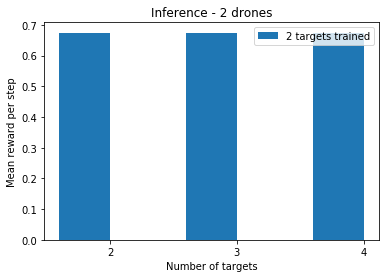

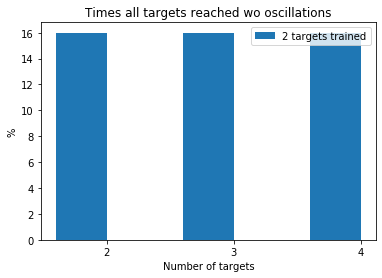

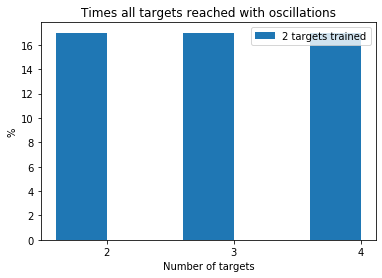

In [5]:
fig,ax=plt.subplots()
labels=[2,3,4]
x = np.arange(len(labels))
width=0.4
rects1 = ax.bar(x - width/2, [PERFORMANCES[0]], width, label='2 targets trained')
#rects2 = ax.bar(x+width/2, [PERFORMANCES[3],PERFORMANCES[4],PERFORMANCES[5]], width, label='2 targets trained-proportional')
#rects3 = ax.bar(x + width/2, [PERFORMANCES3[0],PERFORMANCES3[1],PERFORMANCES3[2]], width, label='Centralized',color='red')
#rects2 = ax.bar(x + width, [PERFORMANCES[3],PERFORMANCES[4]], width, label='4 targets trained')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Inference - 2 drones')
plt.xlabel('Number of targets')
plt.ylabel('Mean reward per step')
plt.savefig('Mean_reward7.pdf',format='pdf')
plt.show()

fig,ax=plt.subplots()
x = np.arange(len(labels))
width=0.4
rects1 = ax.bar(x - width/2, [PERFORMANCES2[0]], width, label='2 targets trained')
#rects2 = ax.bar(x + width/2, [PERFORMANCES2[3],PERFORMANCES2[4],PERFORMANCES2[5]], width, label='2 targets trained-proportional')
#rects3 = ax.bar(x + width/2, [PERFORMANCES4[0],PERFORMANCES4[1],PERFORMANCES4[2]], width, label='Centralized',color='red')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Times all targets reached wo oscillations')
plt.xlabel('Number of targets')
plt.ylabel('%')
plt.savefig('Success3.pdf',format='pdf')
plt.show()

fig,ax=plt.subplots()
x = np.arange(len(labels))
width=0.4
rects1 = ax.bar(x - width/2, [PERFORMANCES5[0]], width, label='2 targets trained')
#rects2 = ax.bar(x + width/2, [PERFORMANCES5[3],PERFORMANCES5[4],PERFORMANCES5[5]], width, label='2 targets trained - proportional')
#rects3 = ax.bar(x + width/2, [PERFORMANCES6[0],PERFORMANCES6[1],PERFORMANCES6[2]], width, label='Centralized',color='red')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Times all targets reached with oscillations')
plt.xlabel('Number of targets')
plt.ylabel('%')
plt.savefig('Success4.pdf',format='pdf')
plt.show()

In [ ]:
values=np.load('final.npy')
print (values)

In [ ]:
print (np.random.rand(1))

In [ ]:
plt.style.use('dark_background')
def epsilon(x):
    e=((1-1/(1+np.exp(-x/100)))*np.cos(x/20)*0.5+0.5)*(1/np.exp((x+500)/500))
    return e

e = []
for i in range(1000):
    e.append(epsilon(i-500))
plt.figure(figsize=(10,5))
plt.xlabel('Episode index')
plt.ylabel('Epsilon')
plt.title('Epsilon per episode')
x_axis = np.asarray(range(0,1000, 1))
plt.plot(x_axis,np.asarray(e),'r')
plt.grid()

In [ ]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(8,10))
ax[0,0].set_xlabel('Episode index')
ax[0,0].set_ylabel('Epsilon')
ax[0,0].set_title('Epsilon per episode')
x_axis = np.asarray(range(0,1000, 1))
ax[0,0].plot(x_axis,np.asarray(e),'r')
ax[0,0].grid()

st = []
for ep in range(1000):
    st.append(5000/(ep+1)**(1/3))
    
ax[0,1].set_xlabel('Episode index')
ax[0,1].set_ylabel('Steps')
ax[0,1].set_title('Steps per episode')
x_axis = np.asarray(range(0, 1000, 1))
ax[0,1].plot(x_axis,np.asarray(st),'y')
ax[0,1].grid()

batch_size = 40
BS = []
for i in range(1000):
    BS.append(batch_size+80*(i/1000)**2)
    
ax[1,0].set_xlabel('Episode index')
ax[1,0].set_ylabel('Batch size')
ax[1,0].set_title('Batch size per episode')
x_axis = np.asarray(range(0, 1000, 1))
ax[1,0].plot(x_axis,np.asarray(BS),'g')
plt.grid()

size_MM = 1000*20
LM = []
bs = []
LM.append(size_MM)
BS.append(20*(st[0]))
for i in range(1000):
    if i>0:
        LM.append(LM[i-1]+st[i])
    bs.append(BS[i]*int(st[i]))
    
x_axis = np.asarray(range(0, 1000, 1))
ax[1,1].bar(x_axis, np.asarray(LM))
ax[1,1].bar(x_axis, np.asarray(bs))
ax[1,1].set_xlabel('Episode index')

In [ ]:
print (st[20])

In [ ]:
import random
possible_actions = [0,1,2,3,4]
action = np.random.choice(possible_actions,5,replace=False)
print (action)
print (possible_actions)

In [ ]:
d = np.load('pretrain_example.npy')
print (d.shape)
d=d[0]
print (d.shape)

In [ ]:
print (d[0,0])

In [ ]:
%matplotlib notebook

def generate_data(i):
    return d[i,0],d[i,1],d[i,2],d[i,3]

def updateplot(data):
    mat.set_data(data[0])
    mat1.set_data(data[1])
    mat2.set_data(data[2])
    mat3.set_data(data[3])
    return mat,mat1,mat2,mat3

def data_gen():
    global i
    while True:
        i = i+1
        yield generate_data(i)

i=0 #tick iterator        

fig, (axes) = plt.subplots(nrows=1, ncols=4,figsize=(8, 3))

mat = axes[0].matshow(generate_data(0)[0])
mat1 = axes[1].matshow(generate_data(0)[1])
mat2 = axes[2].matshow(generate_data(9)[2],cmap=plt.cm.hot)
mat3 = axes[3].matshow(generate_data(0)[3],cmap=plt.cm.hot)
anim=animation.FuncAnimation(fig,updateplot,data_gen(),interval=50,save_count=25)

In [12]:
#d = np.load('example.npy')
d=example
print (d.shape)
j=2
d=d[j]

(100, 100, 3, 8, 8)


<IPython.core.display.Javascript object>


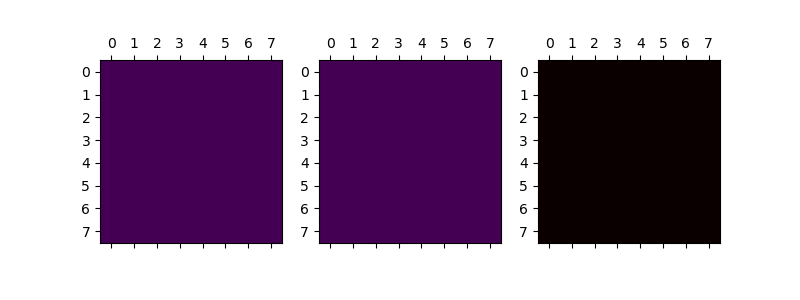

In [13]:
%matplotlib notebook

def generate_data(i):
    return d[i,0],d[i,1],d[i,2]

def updateplot(data):
    mat.set_data(data[0])
    mat1.set_data(data[1])
    mat2.set_data(data[2])
    return mat,mat1,mat2

def data_gen():
    global i
    while True:
        i = i+1
        yield generate_data(i)

i=0 #tick iterator        

fig, (axes) = plt.subplots(nrows=1, ncols=3,figsize=(8, 3))
mat = axes[0].matshow(generate_data(0)[0])
mat1 = axes[1].matshow(generate_data(0)[1])
mat2 = axes[2].matshow(generate_data(0)[2],cmap=plt.cm.hot)
anim=animation.FuncAnimation(fig,updateplot,data_gen(),interval=500,save_count=25)

In [ ]:
fig, (axes) = plt.subplots(nrows=1, ncols=3,figsize=(8, 3))
for j in range(20):
    mat = axes[0].matshow(d[j,0])
    mat1 = axes[1].matshow(d[j,1])
    mat2 = axes[2].matshow(d[j,2],cmap=plt.cm.hot)
    fig.savefig('Test'+str(j))

In [ ]:
fig, (axes) = plt.subplots(nrows=3, ncols=7,figsize=(11, 5))
for i in range(7):
    mat = axes[0,i].matshow(d[i,0])
    mat1 = axes[1,i].matshow(d[i,1])
    mat2 = axes[2,i].matshow(d[i,2],cmap=plt.cm.hot)
fig.savefig('Multi1')